In [1]:
from monai.utils import set_determinism
import torch
import matplotlib.pyplot as plt
import nrrd
import munch
import yaml

# set fixed seed for comparability
set_determinism(seed=0, additional_settings=None)

In [59]:
from trainer_own import LitModel
from datamodule_own import ASOCADataModule, CustomDataset

cwd = "/cluster/work/felixzr/TDT4265_StarterCode_2024/pytorch-lightning-template/"
config = munch.munchify(yaml.load(open(cwd + "config_copy.yaml"), Loader=yaml.FullLoader))

# model = LitModel.load_from_checkpoint(checkpoint_path="checkpoints/ASOCA/ASOCA_idun/best_model:epoch=32-val_acc=0.0000.ckpt", config=config)
model = LitModel.load_from_checkpoint(checkpoint_path="checkpoints/ASOCA/ASOCA_idun/best_model:epoch=32-val_acc=0.0011.ckpt", config=config)

model.eval() ## set to evaluation mode

LitModel(
  (model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        (submodule): 

In [43]:
dm = ASOCADataModule(
    data_dir=config.data_dir,
    batch_size=1, #config.batch_size,
    num_workers=config.num_workers,
    train_split_ratio=config.train_split_ratio,
    data_root=config.data_root
)
dm.setup()
dataloader = dm.test_dataloader()

In [44]:
device = "cuda"
model.to(device)

predictions = []
with torch.no_grad():
    for inputs in dataloader:
        # print("TEST")
        outputs = model.forward(inputs["sample"].to(device))
        predictions.append(outputs)

len(predictions)

1

In [45]:
predictions[0].shape

torch.Size([1, 1, 512, 512, 224])

In [46]:
# predictions[1].shape

In [47]:
data, _ = nrrd.read("/cluster/work/felixzr/TDT4265_StarterCode_2024/data/ASOCA/Normal/CTCA/Normal_8.nrrd")
data_gt, _ = nrrd.read("/cluster/work/felixzr/TDT4265_StarterCode_2024/data/ASOCA/Normal/Annotations/Normal_8.nrrd")

data_gt.shape

(512, 512, 224)

In [48]:
predictions_plot = predictions[0][0][0].cpu()

117

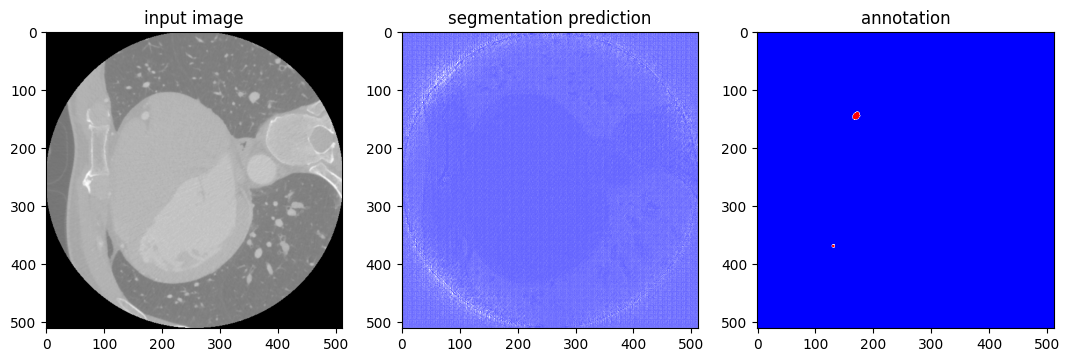

In [57]:
import numpy as np
i = np.random.randint(data_gt.shape[2]-1)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input image")
axs[0].imshow(data[:, :, i], cmap="gray")

axs[1].set_title("segmentation prediction")
axs[1].imshow(predictions_plot[:,:,i], cmap="bwr")

axs[2].set_title("annotation")
axs[2].imshow(data_gt[:,:,i], cmap="bwr")

i

In [53]:
torch.min(predictions[0]).item(), torch.max(predictions[0]).item(), torch.mean(predictions[0]).item(), torch.median(predictions[0]).item(), torch.std(predictions[0]).item()

(-10.974878311157227,
 19.42268943786621,
 0.16529209911823273,
 -0.0009850114583969116,
 0.8646460175514221)

In [54]:
predictions_plot

metatensor([[[ 0.3563,  0.2420, -0.3491,  ...,  0.0800, -0.0967,  0.2973],
         [ 0.7045,  0.1380,  0.6680,  ..., -0.1992,  0.1723, -0.0378],
         [ 0.2336,  0.6615, -0.2572,  ...,  0.3541, -0.0537, -0.1274],
         ...,
         [ 0.3162,  0.1140,  0.5179,  ..., -0.1396,  0.1952,  0.1000],
         [ 0.4719,  0.4642, -0.0866,  ...,  0.5390,  0.1117, -0.0052],
         [-0.3026,  0.1261, -0.0561,  ..., -0.0993,  0.2005,  0.1233]],

        [[ 0.0684,  0.5945, -0.0082,  ...,  0.3336,  0.1159, -0.1180],
         [ 0.3241,  1.1085,  0.0430,  ...,  0.3076,  0.0389,  0.3789],
         [-0.1387, -0.2507,  0.2948,  ..., -0.5544,  0.0166, -0.1757],
         ...,
         [ 0.3612,  1.0351, -0.0858,  ..., -0.0129, -0.1828,  0.8499],
         [-0.2518, -0.1702,  0.1779,  ..., -0.3668, -0.1664, -0.1058],
         [ 0.1191,  0.8195, -0.4121,  ...,  0.0329, -0.2407,  0.5480]],

        [[ 0.1277,  0.4064,  0.2792,  ...,  0.1286,  0.0541,  0.1736],
         [ 1.0021, -0.1482,  0.2146,  ...

In [52]:
data_gt

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [67]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load("pretrained/best_metric_model.pth"))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [68]:
predictions = []
with torch.no_grad():
    for inputs in dataloader:
        # print("TEST")
        outputs = model.forward(inputs["sample"].to(device))
        predictions.append(outputs)

len(predictions)

1

In [69]:
predictions_plot = predictions[0][0][0].cpu()

67

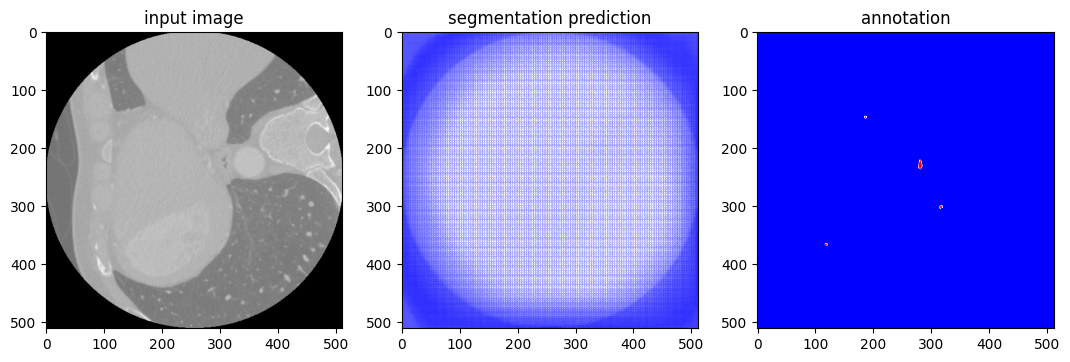

In [70]:
import numpy as np
i = np.random.randint(data_gt.shape[2]-1)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input image")
axs[0].imshow(data[:, :, i], cmap="gray")

axs[1].set_title("segmentation prediction")
axs[1].imshow(predictions_plot[:,:,i], cmap="bwr")

axs[2].set_title("annotation")
axs[2].imshow(data_gt[:,:,i], cmap="bwr")

i

In [72]:
torch.min(predictions[0]).item(), torch.max(predictions[0]).item(), torch.mean(predictions[0]).item(), torch.median(predictions[0]).item(), torch.std(predictions[0]).item()

(-19.945606231689453,
 29.62525177001953,
 0.7413540482521057,
 0.9670121073722839,
 8.234626770019531)

In [74]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [76]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)

/cluster/home/felixzr/.conda/envs/tdt4265/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


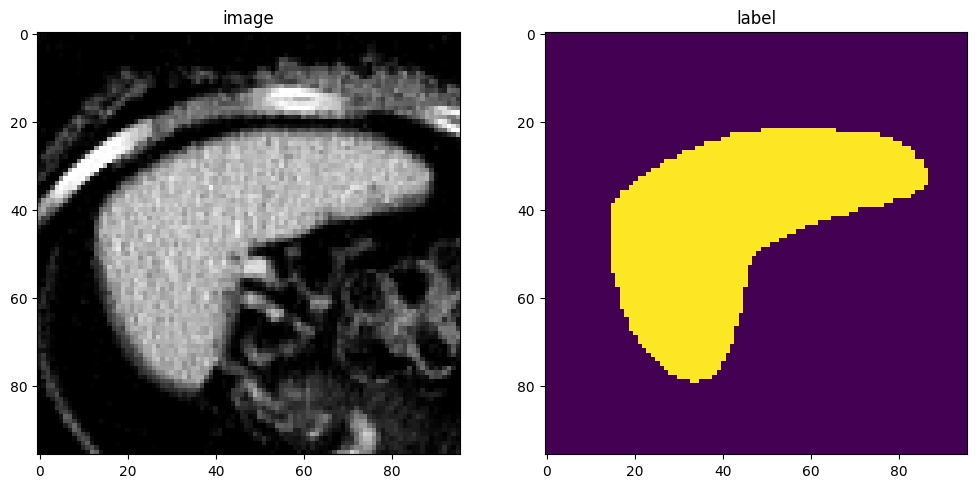

In [99]:
train_files = [{'image': '/cluster/work/felixzr/TDT4265_StarterCode_2024/pytorch-lightning-template/pretrained/Task09_Spleen/imagesTr/spleen_10.nii.gz', 'label': '/cluster/work/felixzr/TDT4265_StarterCode_2024/pytorch-lightning-template/pretrained/Task09_Spleen/labelsTr/spleen_10.nii.gz'}]

check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 50], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 50])
plt.show()

In [87]:
prediction = model(check_data["image"].to(device)).to("cpu").detach()

36

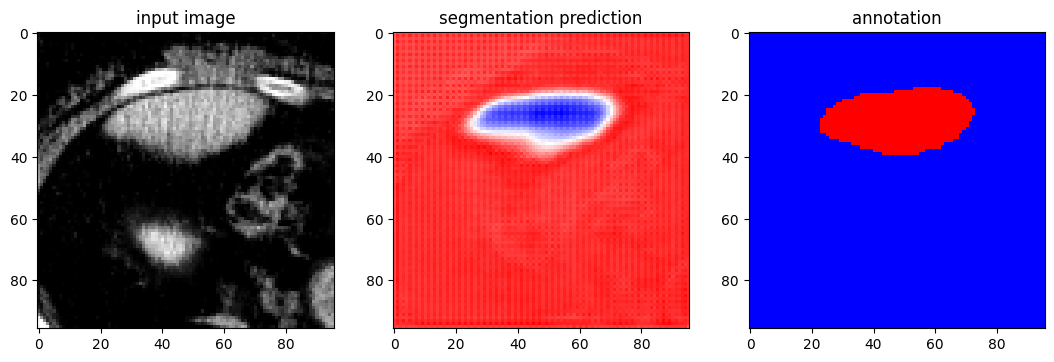

In [94]:
import numpy as np
i = np.random.randint(image.shape[2]-1)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input image")
axs[0].imshow(image[:, :, i], cmap="gray")

axs[1].set_title("segmentation prediction")
axs[1].imshow(prediction[0][0][:,:,i], cmap="bwr")

axs[2].set_title("annotation")
axs[2].imshow(label[:,:,i], cmap="bwr")

i

In [97]:
torch.min(prediction[0]).item(), torch.max(prediction[0]).item(), torch.mean(prediction[0]).item(), torch.median(prediction[0]).item(), torch.std(prediction[0]).item()

(-18.038719177246094,
 26.41714859008789,
 0.419491708278656,
 0.4351467490196228,
 4.425759315490723)

In [82]:
check_data["image"].shape

# batch size, channels (1 means output 0 and 1), spatial dims

torch.Size([4, 1, 96, 96, 96])

TypeError: Invalid shape (512, 512, 2) for image data

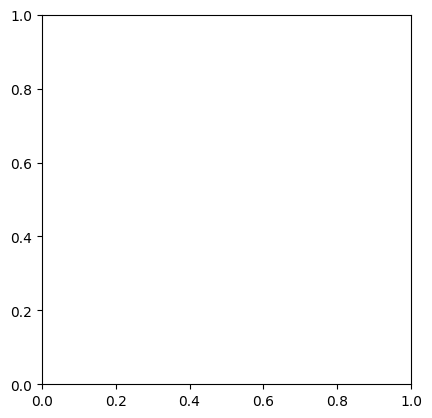

In [100]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the .nii.gz file
img = nib.load('pretrained/out/spleen_30/spleen_30_seg.nii.gz')

# Get the image data
data = img.get_fdata()

# Plot a slice of the data
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
plt.colorbar()
plt.show()
